In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

# Step 1 : Data Ingestion

In [2]:
import pandas as pd
df = pd.read_csv("drug200.csv")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# Step 2 : Basic data quality checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

# Step 3 : Saperate X and Y

In [6]:
X = df.drop(columns=["Drug"])
Y = df[["Drug"]]

In [7]:
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [8]:
Y.head()

,Drug
0,DrugY
1,drugC
2,drugC
3,drugX
4,DrugY


# Step 4 : Feature engineering

In [9]:
X.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
dtype: object

In [10]:
cat = list(X.columns[X.dtypes == "object"])
con = list(X.columns[X.dtypes != "object"])

In [11]:
cat

['Sex', 'BP', 'Cholesterol']

In [12]:
con

['Age', 'Na_to_K']

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [15]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
)

In [16]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, con),
        ("cat", cat_pipe, cat)
    ]
).set_output(transform="pandas")

In [17]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Na_to_K']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'BP', 'Cholesterol'])])

In [18]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Age,num__Na_to_K,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL
0,-1.291591,1.286522,0.0,0.0,0.0,0.0
1,0.162699,-0.415145,1.0,1.0,0.0,0.0
2,0.162699,-0.828558,1.0,1.0,0.0,0.0
3,-0.988614,-1.149963,0.0,0.0,1.0,0.0
4,1.011034,0.271794,0.0,1.0,0.0,0.0


# Step 5 : train_test_split

In [19]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.4, random_state=41)

In [20]:
xtrain.head()

,num__Age,num__Na_to_K,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL
116,1.374607,-0.911824,1.0,0.0,1.0,1.0
112,-0.564446,-0.959562,1.0,1.0,0.0,1.0
174,-0.140278,-0.460525,1.0,0.0,0.0,1.0
44,0.344485,-0.525888,0.0,0.0,1.0,1.0
32,0.283889,-0.703660,1.0,1.0,0.0,1.0


In [21]:
ytrain.head()

,Drug
116,drugX
112,drugX
174,drugA
44,drugX
32,drugX


In [22]:
xtest.head()

,num__Age,num__Na_to_K,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL
96,0.829248,3.075618,0.0,1.0,0.0,0.0
63,0.041508,-1.070583,1.0,1.0,0.0,1.0
168,0.405080,0.960122,0.0,1.0,0.0,1.0
196,-1.715759,-0.565995,1.0,1.0,0.0,0.0
68,0.586866,1.189795,1.0,0.0,1.0,0.0


In [23]:
ytest.head()

,Drug
96,DrugY
63,drugX
168,DrugY
196,drugC
68,DrugY


In [24]:
xtrain.shape

(120, 6)

In [25]:
xtest.shape

(80, 6)

# Step 6 : Model Building

In [26]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=5,
    criterion="entropy"
)

In [27]:
model.fit(xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       min_samples_split=5)

In [28]:
model.score(xtrain, ytrain)

1.0

In [29]:
model.score(xtest, ytest)

0.9875

### Hyperparameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    "max_depth" : [2, 3, 4, 5, 6, 7],
    "min_samples_leaf" : [2 ,3, 4, 5, 6, 7, 8, 9],
    "min_samples_split" : [2, 3, 4, 5, 6, 7, 8, 9],
    "criterion" : ["gini", "entropy"]
}

In [31]:
model = DecisionTreeClassifier()

gscv = GridSearchCV(model, param_grid=params, cv=5, scoring="f1_macro")
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='f1_macro')

In [32]:
gscv.best_score_

np.float64(0.980952380952381)

In [33]:
gscv.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [34]:
best_dtc = gscv.best_estimator_
best_dtc

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

# Step 7 : Model evaluation

In [35]:
best_dtc.score(xtrain, ytrain)

1.0

In [36]:
best_dtc.score(xtest, ytest)

0.9875

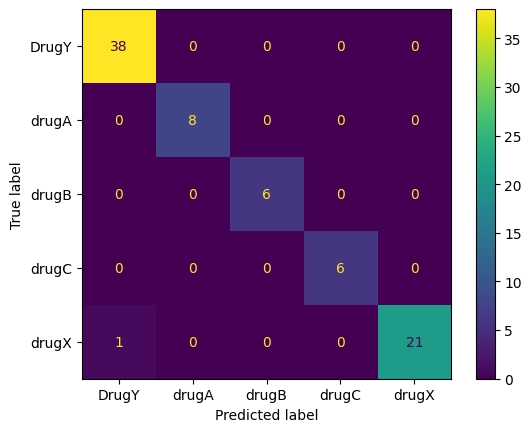

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_dtc, xtest, ytest)

In [38]:
ytest_pred = best_dtc.predict(xtest)
ytest_pred[0:5]

array(['DrugY', 'drugX', 'DrugY', 'drugC', 'DrugY'], dtype=object)

In [39]:
ytest.head()

,Drug
96,DrugY
63,drugX
168,DrugY
196,drugC
68,DrugY


In [40]:
ytest_prob = best_dtc.predict_proba(xtest)
ytest_prob[0:5]


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [41]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

       DrugY       0.97      1.00      0.99        38
       drugA       1.00      1.00      1.00         8
       drugB       1.00      1.00      1.00         6
       drugC       1.00      1.00      1.00         6
       drugX       1.00      0.95      0.98        22

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



# Plot decision Tree

In [43]:
xtrain.columns

Index(['num__Age', 'num__Na_to_K', 'cat__Sex_M', 'cat__BP_LOW',
       'cat__BP_NORMAL', 'cat__Cholesterol_NORMAL'],
      dtype='object')

In [44]:
best_dtc.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [45]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [46]:
ytrain.value_counts()

Drug 
DrugY    53
drugX    32
drugA    15
drugB    10
drugC    10
Name: count, dtype: int64

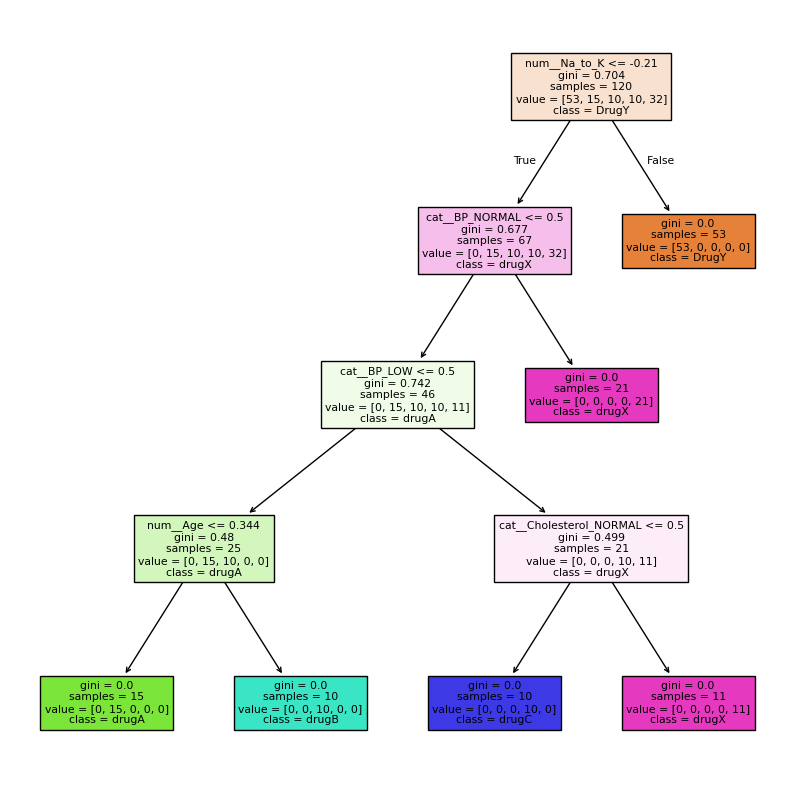

In [47]:
plt.figure(figsize=(10, 10))
plot_tree(best_dtc, feature_names=xtrain.columns, class_names=best_dtc.classes_, filled=True)
plt.show()

In [48]:
best_dtc.feature_importances_

array([0.14198383, 0.46314572, 0.        , 0.13789285, 0.13302346,
       0.12395414])

In [49]:
xtrain.columns

Index(['num__Age', 'num__Na_to_K', 'cat__Sex_M', 'cat__BP_LOW',
       'cat__BP_NORMAL', 'cat__Cholesterol_NORMAL'],
      dtype='object')

In [50]:
imp = pd.Series(best_dtc.feature_importances_, index=xtrain.columns)
imp

num__Age                   0.141984
num__Na_to_K               0.463146
cat__Sex_M                 0.000000
cat__BP_LOW                0.137893
cat__BP_NORMAL             0.133023
cat__Cholesterol_NORMAL    0.123954
dtype: float64

In [52]:
imp.sort_values(ascending=False)

num__Na_to_K               0.463146
num__Age                   0.141984
cat__BP_LOW                0.137893
cat__BP_NORMAL             0.133023
cat__Cholesterol_NORMAL    0.123954
cat__Sex_M                 0.000000
dtype: float64

# Out of sample predictions

In [53]:
xnew = pd.read_csv("DrugTest.csv")
xnew

,Age,Sex,BP,Cholesterol,Na_to_K
0,22.0,F,HIGH,NORMAL,22.818
1,15.0,M,HIGH,NORMAL,17.206
2,67.0,M,NORMAL,NORMAL,9.514
3,68.0,M,NaN,HIGH,11.009
4,70.0,F,NORMAL,HIGH,NaN
5,67.0,F,NORMAL,HIGH,15.891
6,NaN,M,NORMAL,HIGH,25.786
7,51.0,M,HIGH,NORMAL,11.343
8,23.0,F,HIGH,HIGH,25.355
9,35.0,M,LOW,NORMAL,9.170


In [54]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Na_to_K']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'BP', 'Cholesterol'])])

In [55]:
xnew_pre = pre.transform(xnew)

In [56]:
xnew_pre

,num__Age,num__Na_to_K,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL
0,-1.352186,0.934448,0.0,0.0,0.0,1.0
1,-1.776354,0.155639,1.0,0.0,0.0,1.0
2,1.374607,-0.911824,1.0,0.0,1.0,1.0
3,1.435202,-0.704354,1.0,0.0,0.0,0.0
4,1.556393,-0.298088,0.0,0.0,1.0,0.0
5,1.374607,-0.026851,0.0,0.0,1.0,0.0
6,0.041508,1.346334,1.0,0.0,1.0,0.0
7,0.405080,-0.658003,1.0,0.0,0.0,1.0
8,-1.291591,1.286522,0.0,0.0,0.0,0.0
9,-0.564446,-0.959562,1.0,1.0,0.0,1.0


In [58]:
pred = best_dtc.predict(xnew_pre)
pred[0:5]

array(['DrugY', 'DrugY', 'drugX', 'drugB', 'drugX'], dtype=object)

In [59]:
proba = best_dtc.predict_proba(xnew_pre)
proba[0:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [61]:
xnew["Drug"] = pred
xnew[best_dtc.classes_] = proba

In [62]:
xnew

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,DrugY,drugA,drugB,drugC,drugX
0,22.0,F,HIGH,NORMAL,22.818,DrugY,1.0,0.0,0.0,0.0,0.0
1,15.0,M,HIGH,NORMAL,17.206,DrugY,1.0,0.0,0.0,0.0,0.0
2,67.0,M,NORMAL,NORMAL,9.514,drugX,0.0,0.0,0.0,0.0,1.0
3,68.0,M,NaN,HIGH,11.009,drugB,0.0,0.0,1.0,0.0,0.0
4,70.0,F,NORMAL,HIGH,NaN,drugX,0.0,0.0,0.0,0.0,1.0
5,67.0,F,NORMAL,HIGH,15.891,DrugY,1.0,0.0,0.0,0.0,0.0
6,NaN,M,NORMAL,HIGH,25.786,DrugY,1.0,0.0,0.0,0.0,0.0
7,51.0,M,HIGH,NORMAL,11.343,drugB,0.0,0.0,1.0,0.0,0.0
8,23.0,F,HIGH,HIGH,25.355,DrugY,1.0,0.0,0.0,0.0,0.0
9,35.0,M,LOW,NORMAL,9.170,drugX,0.0,0.0,0.0,0.0,1.0


In [63]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [64]:
import joblib

In [65]:
joblib.dump(pre, "DrugPre.joblib")

['DrugPre.joblib']

In [66]:
joblib.dump(best_dtc, "DrugModel.joblib")

['DrugModel.joblib']

In [67]:
p = joblib.load("DrugPre.joblib")
p

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Na_to_K']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'BP', 'Cholesterol'])])

In [68]:
m = joblib.load("DrugModel.joblib")
m

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)